# Tutorial de Big Data
## Tutorial 14

**Objetivo:** 
Que se familiaricen con el análisis de supervivencia 

### Datos censurados
La variable de resultado tiene una particularidad y que representa el *tiempo hasta que un evento ocurre*

Ejemplos:
- Predecir el tiempo que sobrevivirá un paciente enfermo --> Datos censurados de los pacientes que sobreviven más tiempo que el que dura el estudio (y no sabemos cuántos años viven)
- Predecir *churn* (el preoceso por el cual un cliente da de baja un servicio) --> Datos censurados de los clientes que no cancelaron el servicio al final del periodo analizado
    


Para cada individuo hay:
- un **tiempo de supervivencia real**, **T**, es decir el momento en el que el evento de interés ocurre (por ejemplo, churn, o fallecimiento de un pacinente)
- un **tiempo de censura (censoring time)**, **C**, es decir el tiempo en el que ocurre el censoring (una persona deja un estudio o finaliza el estudio)

Observamos la variable aleatoria **Y**:

Y=min(T,C)

Podremos observar lo que ocurra primero, T o C (Y=T si T<C e Y=C si C<T)

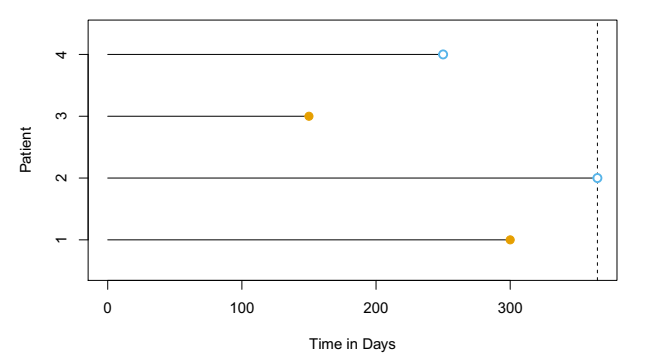

*¿Por qué ocurre el censoring?*
- Para el paciente 2: porque estaba vivo cuando finalizó el estudio
- Para el paciente 4: porque dejó el estudio

Para los pacientes 1 y 3 vemos el momento en que ocurre el evento (T)

*Estado de observación de la variable dependiente* (**𝛿**)
- 𝛿=1 si observamos el verdadero tiempo de supervivencia (T), (es decir T<=C)
- 𝛿=0 si observamos el tiempo censurado (es decir, T>C)


#### Curva o función de supervivencia de Kaplan-Meier
𝑆(𝑡)=Pr⁡(𝑇>𝑡)

- Intuición: probabilidad de que el tiempo de supervivencia sea mayor al tiempo 𝑡 (en el ejemplo de churn, la probabildiad de que un cliente cancele la suscripción luego de 𝑡)
- Función decreciente en 𝑡: a mayor 𝑡 cae la probabilidad de supervivencia T

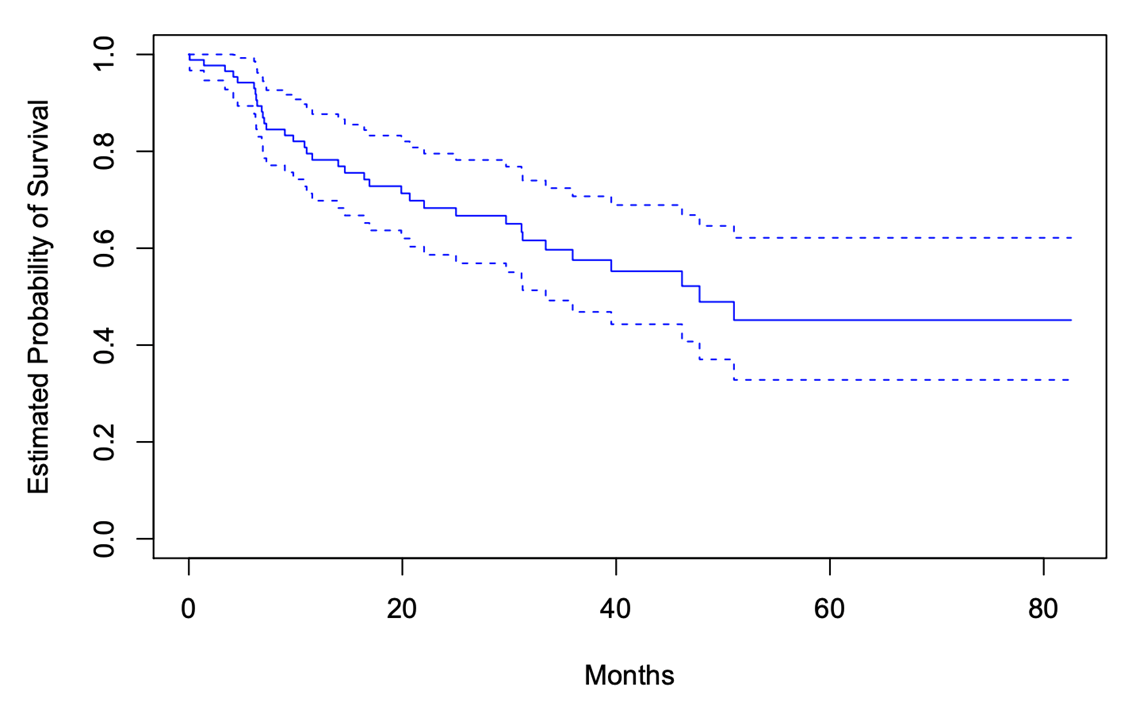

#### Un ejemplo

Vamos a trabajar con el dataset BrainCancer, que contiene los tiempos de supervivencia de pacientes con tumores cerebrales que están realizando un tratamiento con radiación. 

Los predictores son:
- gtv (volumen tumoral bruto) 
- sex 
- diagnosis (tipo de tumor)
- loc (localización del tumor)
- ki (índice de Karnofsky)
- stereo (método de radiación)

En el dataset también se encuentran las variables time y status que hacen referencia al período y al estado de observación de la variable dependiente, respectivamente

Sólo 53 de los 88 pacientes seguían vivos al final del estudio.

In [1]:
from matplotlib import pyplot as plt
from matplotlib.pyplot import subplots
import numpy as np
import pandas as pd
from ISLP import load_data

Para análisis de supervivencia, vamos a usar la librería [lifelines](https://lifelines.readthedocs.io/en/latest/)

In [2]:
#!pip install lifelines
from lifelines import KaplanMeierFitter, CoxPHFitter
from lifelines.statistics import logrank_test, multivariate_logrank_test

In [3]:
BrainCancer = load_data('BrainCancer')
print(BrainCancer.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 8 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sex        88 non-null     category
 1   diagnosis  87 non-null     category
 2   loc        88 non-null     category
 3   ki         88 non-null     int64   
 4   gtv        88 non-null     float64 
 5   stereo     88 non-null     category
 6   status     88 non-null     int64   
 7   time       88 non-null     float64 
dtypes: category(4), float64(2), int64(2)
memory usage: 3.8 KB
None


In [4]:
BrainCancer['sex'].value_counts()

Female    45
Male      43
Name: sex, dtype: int64

In [5]:
BrainCancer['diagnosis'].value_counts()

Meningioma    42
HG glioma     22
Other         14
LG glioma      9
Name: diagnosis, dtype: int64

In [6]:
# Estado de observación de la variable dependiente
BrainCancer['status'].value_counts() #   35 pacientes fallecieron antes de que termine el estudio
# status=1 indica una observación sin censura (en general, paciente que murió)
# status=0 indica una observación con censura

0    53
1    35
Name: status, dtype: int64

In [7]:
# Momento en que ocurre el evento o la censura
BrainCancer['time'].describe()

count    88.000000
mean     27.457500
std      20.124412
min       0.070000
25%      10.392500
50%      24.030000
75%      41.597500
max      82.560000
Name: time, dtype: float64

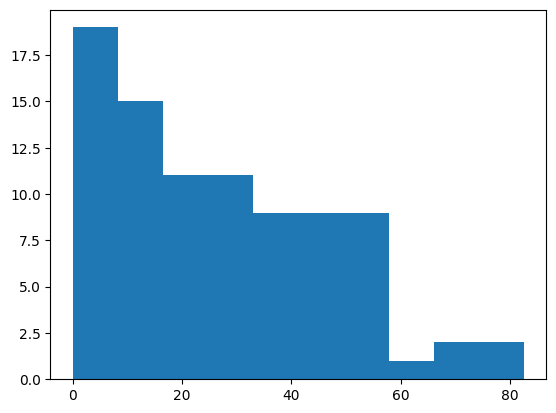

In [8]:
plt.hist(BrainCancer['time'])
plt.show()

###### ¿Cómo estimar la probabilidad de que un paciente sobreviva al menos 20 meses (t=20)?

Uno inicialmente podría pensar que tomando a todas las personas que vemos cuando t>=20, podemos estimar esa probabilidad...

In [9]:
print("T>=20:", (BrainCancer['time'] >= 20).sum())

T>=20: 48


¿Entonces 48/88 (55%) sobreviven al menos 20 meses? 

No! Tenemos algunos casos para los que T<20, pero en realidad el dato está censurado (es decir, no sabemos si murieron o salieron del estudio):

In [10]:
len(BrainCancer.loc[(BrainCancer['status'] == 0) & (BrainCancer['time'] < 20)])

17

Entonces decir que la probabilidad de que un paciente sobreviva al menos 20 meses es 55% es una subestimación... Estábamos  asumiendo que los 17 datos censurados eran observaciones de personas que no sobrevivieron, y no sabemos si fue así realmente

Veamos entonces la ***curva de supervivencia**

<Axes: xlabel='timeline'>

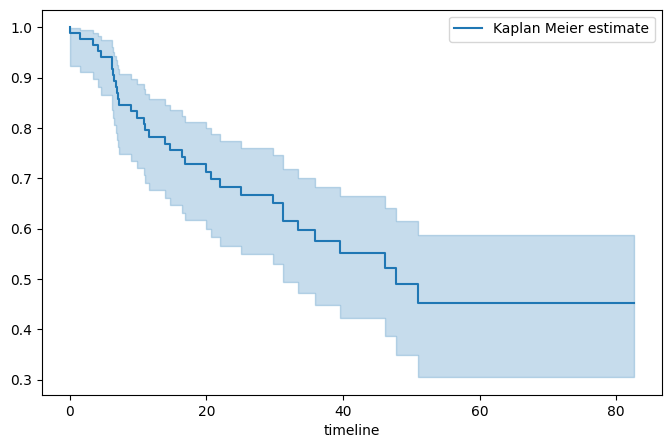

In [11]:
fig, ax = subplots(figsize=(8,5))
km = KaplanMeierFitter()
km_brain = km.fit(durations=BrainCancer['time'], event_observed=BrainCancer['status'])
km_brain.plot(label='Kaplan Meier estimate', ax=ax)

In [12]:
# Probabilidad de supervivencia cuando time = 20
time_point = 20
survival_prob = km_brain.predict(time_point)*100
print(f'Probabilidad de supervivencia cuando time = {time_point}: {survival_prob:.2f}%')

Probabilidad de supervivencia cuando time = 20: 71.32%


Ahora veamos estas curvas, separando por género

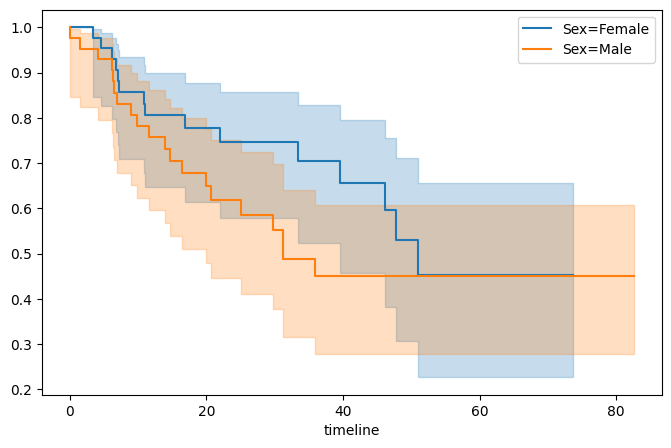

In [13]:
# Curvas de supervivencia por género
fig, ax = subplots(figsize=(8,5))
by_sex = {}  # diccionario en el que guardaremos los datos de mujeres y varones
for sex, df in BrainCancer.groupby('sex'):
    by_sex[sex] = df
    km_sex = km.fit(durations=df['time'], event_observed=df['status'])
    km_sex.plot(label='Sex=%s' % sex, ax=ax)

Text(0.5, 1.0, 'Survival of different gender group')

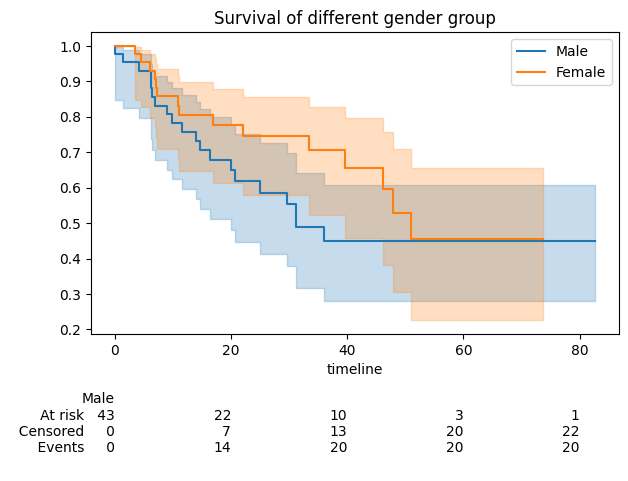

In [21]:
# Similar, de otra forma

ax = plt.subplot(111)
m = (BrainCancer["sex"] == 'Male')
f = (BrainCancer["sex"] == 'Female')
kmf = KaplanMeierFitter()
kmf.fit(durations = BrainCancer[m]['time'], event_observed = BrainCancer[m]['status'], label = "Male")
kmf.plot_survival_function(ax = ax, at_risk_counts = True)
kmf.fit(durations = BrainCancer[f]['time'], event_observed = BrainCancer[f]['status'], label = "Female")
kmf.plot_survival_function(ax = ax)
plt.title("Survival of different gender group")


In [15]:
by_sex

{'Female':        sex   diagnosis             loc   ki    gtv stereo  status   time
 0   Female  Meningioma  Infratentorial   90   6.11    SRS       0  57.64
 2   Female  Meningioma  Infratentorial   70   7.95    SRS       0  26.46
 3   Female   LG glioma  Supratentorial   80   7.61    SRT       1  47.80
 5   Female  Meningioma  Supratentorial   80   4.82    SRS       0  52.75
 8   Female  Meningioma  Supratentorial   70  12.16    SRT       0  34.66
 11  Female  Meningioma  Infratentorial   90   6.54    SRS       0  34.26
 12  Female  Meningioma  Infratentorial   90   0.63    SRS       0  32.98
 14  Female  Meningioma  Supratentorial   60   9.18    SRT       0  41.44
 15  Female   HG glioma  Supratentorial   70  11.38    SRS       1   7.05
 16  Female       Other  Infratentorial   60  24.00    SRT       1   6.82
 19  Female  Meningioma  Supratentorial   90   2.50    SRT       0  30.16
 20  Female  Meningioma  Supratentorial   80   2.82    SRS       0  24.39
 22  Female       Other  Inf

¿Como testeamos formalmente si la supervivencia es igual entre dos grupos (por ejemplo, hombres y mujeres)?
**Log-rank test**

In [16]:
logrank_test(durations_A = by_sex['Male']['time'], 
             durations_B = by_sex['Female']['time'],
             event_observed_A = by_sex['Male']['status'],
             event_observed_B = by_sex['Female']['status'])

<lifelines.StatisticalResult: logrank_test>
               t_0 = -1
 null_distribution = chi squared
degrees_of_freedom = 1
         test_name = logrank_test

---
 test_statistic    p  -log2(p)
           1.44 0.23      2.12

El p-valor resultante es 0,23. Como es grande (mayor a 0,05) indica que no hay pruebas de una diferencia de supervivencia entre los dos sexos (es decir, que no podemos rechazar la H0 de que no hay diferencias en las curvas de supervivencia de mujeres y varones)

##### Regresión con una respuesta de supervivencia: Modelo de Cox

Objetivo: Predecir T tiempo verdadero de supervivencia no observable para los casos censurados

Modelamos el riesgo (hazard) de que ocurra el evento (fallecimiento del paciente)

In [22]:
BrainCancer['female'] = BrainCancer['sex'].map({'Male': 0, 'Female': 1})

In [23]:
coxph = CoxPHFitter()
cox_fit = coxph.fit(BrainCancer[['time', 'status', 'female']], duration_col='time', event_col='status')

In [24]:
# Resultados
cox_fit.summary

,coef,exp(coef),se(coef),coef lower 95%,coef upper 95%,exp(coef) lower 95%,exp(coef) upper 95%,cmp to,z,p,-log2(p)
covariate,,,,,,,,,,,
female,-0.407668,0.665199,0.342004,-1.077984,0.262648,0.340281,1.300368,0.0,-1.191998,0.233262,2.099977


In [25]:
# Resultados (versión breve)
cox_fit.summary[['coef', 'se(coef)', 'p']]

,coef,se(coef),p
covariate,,,
female,-0.407668,0.342004,0.233262


Con un predictor, esta regresión nos muestra lo mismo que el log-rank test.
También tenemos evidencia de que no hay una diferencia significativa en la supervivencia entre varones y mujeres

Ahora un modelo con todos los predictores

In [26]:
BrainCancer.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype   
---  ------     --------------  -----   
 0   sex        88 non-null     category
 1   diagnosis  87 non-null     category
 2   loc        88 non-null     category
 3   ki         88 non-null     int64   
 4   gtv        88 non-null     float64 
 5   stereo     88 non-null     category
 6   status     88 non-null     int64   
 7   time       88 non-null     float64 
 8   female     88 non-null     category
dtypes: category(5), float64(2), int64(2)
memory usage: 4.0 KB


In [27]:
import pandas as pd
from sklearn.preprocessing import LabelEncoder

BrainCancer_encoded = pd.get_dummies(BrainCancer, columns=['sex', 'diagnosis', 'loc', 'stereo'], drop_first=True)
BrainCancer_encoded.drop(columns='female', inplace=True)
BrainCancer_encoded

,ki,gtv,status,time,sex_Male,diagnosis_LG glioma,diagnosis_Meningioma,diagnosis_Other,loc_Supratentorial,stereo_SRT
0,90,6.11,0,57.64,0,0,1,0,0,0
1,90,19.35,1,8.98,1,0,0,0,1,1
2,70,7.95,0,26.46,0,0,1,0,0,0
3,80,7.61,1,47.80,0,1,0,0,1,1
4,90,5.06,1,6.30,1,0,0,0,1,1
...,...,...,...,...,...,...,...,...,...,...
83,80,0.16,1,20.69,1,0,0,0,1,1
84,80,19.81,1,6.39,1,0,0,0,1,1
85,90,2.50,0,32.82,1,0,1,0,1,1
86,90,2.02,0,42.07,1,0,1,0,1,0


In [28]:
cox_fit_all = coxph.fit(BrainCancer_encoded, duration_col='time', event_col='status')
cox_fit_all.summary[['coef', 'se(coef)', 'p']] 

,coef,se(coef),p
covariate,,,
ki,-0.057920,0.018313,0.001563
gtv,0.036041,0.022623,0.111125
sex_Male,0.097854,0.360701,0.786169
diagnosis_LG glioma,-1.091266,0.573943,0.057256
diagnosis_Meningioma,-2.082012,0.453688,0.000004
diagnosis_Other,-1.235849,0.625866,0.048311
loc_Supratentorial,0.375835,0.697787,0.590156
stereo_SRT,0.139636,0.598031,0.815379


Coeficientes negativos indican menor riesgo (o mayor supervivencia), mientras que coeficientes positivos indican mayor riesgo (menor supervivencia)

Los predictores estadísticamente significativos son: ki, diagnosis_Meningioma y diagnosis_Other.

- **ki** tiene un **coeficiente negativo** --> mayores valores del índice de Karnofsky están asociados con **menor riesgo** (**mayor supervivencia**). Computando el hazard ratio como exp(-0.057920)=0.94 vemos que un aumento de una unidad en ki está asociado con una reducción del riesgo de aproximadamente el 6% (surge de hacer 1-0.94)
- **diagnosis_Meningioma** tiene un **coeficiente negativo** --> tener un diagnóstico de Meningioma está asociado con **menor riesgo** respecto a la categoría base diagnosis=HG glioma. (o de otra forma, el riesgo esperado de los pacientes con HG glioma es más alto que el riesgo esperado para los pacientes diagnosticados con Meningioma, manteniendo todo lo demás constante.

In [29]:
import math
print(math.exp(-0.057920))
print(math.exp(-2.082012))

0.9437254424523538
0.12467910530987862
